本次实验以AAAI 2014会议论文数据为基础，要求实现或调用无监督聚类算法，了解聚类方法。

### 任务介绍
每年国际上召开的大大小小学术会议不计其数，发表了非常多的论文。在计算机领域的一些大型学术会议上，一次就可以发表涉及各个方向的几百篇论文。按论文的主题、内容进行聚类，有助于人们高效地查找和获得所需要的论文。本案例数据来源于AAAI 2014上发表的约400篇文章，由[UCI](https://archive.ics.uci.edu/ml/datasets/AAAI+2014+Accepted+Papers!)公开提供，提供包括标题、作者、关键词、摘要在内的信息，希望大家能根据这些信息，合理地构造特征向量来表示这些论文，并设计实现或调用聚类算法对论文进行聚类。最后也可以对聚类结果进行观察，看每一类都是什么样的论文，是否有一些主题。

基本要求：
1. 将文本转化为向量，实现或调用无监督聚类算法，对论文聚类，例如10类（可使用已有工具包例如sklearn）；
2. 观察每一类中的论文，调整算法使结果较为合理；
3. 无监督聚类没有标签，效果较难评价，因此没有硬性指标，跑通即可，主要让大家了解和感受聚类算法，比较简单。

扩展要求：
1. 对文本向量进行降维，并将聚类结果可视化成散点图。

注：group和topic也不能完全算是标签，因为
1. 有些文章作者投稿时可能会选择某个group/topic但实际和另外group/topic也相关甚至更相关；
2. 一篇文章可能有多个group和topic，作为标签会出现有的文章同属多个类别，这里暂不考虑这样的聚类；
3. group和topic的取值很多，但聚类常常希望指定聚合成出例如5/10/20类；
4. 感兴趣但同学可以思考利用group和topic信息来量化评价无监督聚类结果，不作要求。

提示：
1. 高维向量的降维旨在去除一些高相关性的特征维度，保留最有用的信息，用更低维的向量表示高维数据，常用的方法有PCA和t-SNE等；
2. 降维与聚类是两件不同的事情，聚类实际上在降维前的高维向量和降维后的低维向量上都可以进行，结果也可能截然不同；
3. 高维向量做聚类，降维可视化后若有同一类的点不在一起，是正常的。在高维空间中它们可能是在一起的，降维后损失了一些信息。

### 实验过程

#### 一、导入相关包

In [117]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE # 降维
from sklearn.decomposition import PCA #

import re
import nltk # 自然语言处理 英文处理
from scipy import sparse
import seaborn as sns
from collections import Counter

RANDOM_SEED = 20250720

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/limingyuebj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/limingyuebj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/limingyuebj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/limingyuebj/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#### 二、读取数据

In [118]:
data = pd.read_csv('data/data.csv', sep=',')
data.describe()

,title,authors,groups,keywords,topics,abstract
count,398,398,396,398,394,398
unique,398,391,125,398,350,398
top,Kernelized Bayesian Transfer Learning,"Deguang Kong, Chris Ding and Qihe Pan",Novel Machine Learning Algorithms (NMLA),cross-domain learning\ndomain adaptation\nkern...,GTEP: Social Choice / Voting,Transfer learning considers related but distin...
freq,1,3,50,1,7,1


#### 三、数据处理

In [119]:
data = data.fillna('')

In [120]:

# 使用TF-IDF向量化

# 作者单独处理
author_splitter = lambda x: re.split(r"\s+and\s+|\s*,\s*", x)

# nltk 英文处理
def word_tokenize(text):
    words = nltk.word_tokenize(text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    stemmer = nltk.stem.PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

author_vectorizer = TfidfVectorizer(tokenizer=author_splitter)
word_vectorizer = TfidfVectorizer(tokenizer=word_tokenize)


author_vector = author_vectorizer.fit_transform(data['authors'].tolist())
title_vector = word_vectorizer.fit_transform(data['title'].tolist())
groups_vector = word_vectorizer.fit_transform(data['groups'].tolist())
keywords_vector = word_vectorizer.fit_transform(data['keywords'].tolist())
topics_vector = word_vectorizer.fit_transform(data['topics'].tolist())
abstract_vector = word_vectorizer.fit_transform(data['abstract'].tolist())


print(f'title_vector.shape: {title_vector.shape}')
print(f'author_vector.shape: {author_vector.shape}')
print(f'groups_vector.shape: {groups_vector.shape}')
print(f'keywords_vector.shape: {keywords_vector.shape}')
print(f'topics_vector.shape: {topics_vector.shape}')
print(f'abstract_vector.shape: {abstract_vector.shape}')


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


title_vector.shape: (398, 1124)
author_vector.shape: (398, 1105)
groups_vector.shape: (398, 64)
keywords_vector.shape: (398, 1051)
topics_vector.shape: (398, 305)
abstract_vector.shape: (398, 4174)


In [121]:
X_sparse = sparse.hstack([title_vector, author_vector, groups_vector, keywords_vector, topics_vector, abstract_vector])
print(X_sparse.shape)

(398, 7823)


#### 四、模型构建

In [122]:
K = 10

model = KMeans(n_clusters=K, random_state=RANDOM_SEED)

model.fit(X_sparse)

data['label'] = model.labels_



In [123]:
# 观察聚类后的label结果
data[data['label'] == 8][['title', 'groups', 'keywords', 'topics']]


,title,groups,keywords,topics
21,The Complexity of Reasoning with FODD and GFODD,Knowledge Representation and Reasoning (KRR),Decision Diagrams\nComputational Complexity\nF...,KRR: Automated Reasoning and Theorem Proving\n...
35,PREGO: An Action Language for Belief-Based Cog...,Knowledge Representation and Reasoning (KRR),knowledge representation\nsituation calculus\n...,"KRR: Action, Change, and Causality\nKRR: Knowl..."
41,Parallel Materialisation of Datalog Programs i...,AI and the Web (AIW)\nKnowledge Representation...,datalog\nmaterialization\nfixpoint computation...,AIW: Question answering on the web\nAIW: Repre...
45,Recovering from Selection Bias in Causal and S...,Knowledge Representation and Reasoning (KRR)\n...,Causal Inference\nCausal Reasoning\nDo-calculu...,"KRR: Action, Change, and Causality\nRU: Bayesi..."
56,A Parameterized Complexity Analysis of General...,Game Playing and Interactive Entertainment (GP...,Computational social choice\nCP-nets\nFixed-pa...,GTEP: Social Choice / Voting\nKRR: Computation...
66,Querying Inconsistent Description Logic Knowle...,Knowledge Representation and Reasoning (KRR),inconsistency-tolerant query answering\ncomple...,KRR: Ontologies\nKRR: Computational Complexity...
76,The Computational Complexity of Structure-Base...,Knowledge Representation and Reasoning (KRR)\n...,Knowledge Representation and Reasoning\nCausal...,"KRR: Action, Change, and Causality\nKRR: Compu..."
100,A Tractable Approach to ABox Abduction over De...,Knowledge Representation and Reasoning (KRR),ABox abduction\nabductive reasoning\nquery abd...,KRR: Description Logics\nKRR: Diagnosis and Ab...
109,Reasoning on LTL on Finite Traces: Insensitivi...,Knowledge Representation and Reasoning (KRR),Linear Temporal Logic\nFinite Traces\nReasonin...,AIW: AI for web services: semantic description...
113,Programming by Example using Least General Gen...,Applications (APP)\nHeuristic Search and Optim...,Programming by example\nInductive inference\nX...,APP: Intelligent User Interfaces\nAPP: Other A...


#### 五、降维展示

<Axes: >

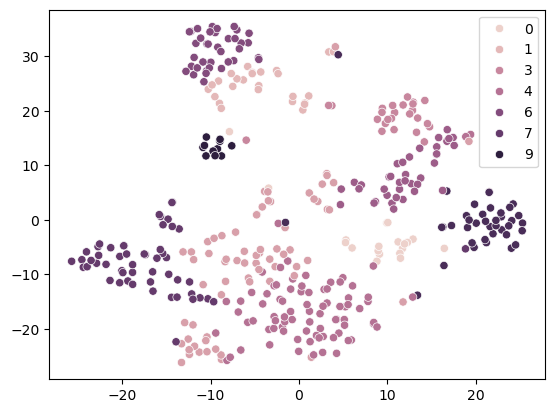

In [124]:

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, init="random")
tnse_features = tsne.fit_transform(X_sparse)

sns.scatterplot(x=tnse_features[:, 0], y=tnse_features[:, 1], hue=model.labels_)



### 实验总结

聚类分析的整体实验流程：

   1. 数据读取观察，各个字段是否有非法值，根据情况填充空字符串或者丢弃掉
   2. 观察各个字段的取值格式，比如作者需要通过 and 逗号切分，整句英文、动词分词、名词复数通过nltk来处理。
   3. 初步处理完成后进行向量化。向量化可以将分词器tokenizer直接当做传入
   4. 通过sparse将系数矩阵进行拼接
   5. 通过聚类算法比如KMeans进行聚类，拿到label
   6. 可以通过观察各个label对应的论文title等字段是否合理
   7. 通过TSNE等方法进行降维，将结果展示出来。